In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import random
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from node2vec import Node2Vec
import time

In [124]:
# Load Karate Club Graph
graph = nx.karate_club_graph()
nodes = list(graph.nodes())

# Create mapping from node to club they're in
node_mapping = {}
for node in graph.nodes(data=True):
    node_mapping[node[0]] = 0 if node[1]["club"] == 'Mr. Hi' else 1
print(node_mapping)

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 0, 17: 0, 18: 1, 19: 0, 20: 1, 21: 0, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1}


In [110]:
# Parameters
num_walks = 80
walk_length = 15
embedding_dim = 128  
num_epochs = 100
learning_rate = 0.01
num_negative_samples = 5

In [111]:
# Generate random walks
def generate_random_walks(graph, num_walks, walk_length):
    walks = []
    for _ in range(num_walks):
        for node in graph.nodes():
            walk = [node]
            for _ in range(walk_length - 1):
                neighbors = list(graph.neighbors(walk[-1]))
                if neighbors:
                    walk.append(random.choice(neighbors))
                else:
                    break
            walks.append(walk)
    return walks

In [125]:
# Convert walks to training pairs
walks = generate_random_walks(graph, num_walks, walk_length)

positive_pairs = []
for walk in walks:
    for i, node in enumerate(walk):
        # 5 node window
        for j in range(max(0, i - 2), min(len(walk), i + 3)):
            if i != j:
                positive_pairs.append((node, walk[j]))
print(len(positive_pairs))

146880


In [126]:
# Negative sampling
all_nodes = set(graph.nodes())
negative_pairs = []
for node1, node2 in positive_pairs:
    for _ in range(num_negative_samples):
        neg_sample = random.choice(nodes)
        while neg_sample == node1 or neg_sample in graph.neighbors(node1):
            neg_sample = random.choice(nodes)
        negative_pairs.append((node1, neg_sample))

In [127]:
# Prepare training data
train_data = positive_pairs + negative_pairs
train_labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

# Convert to PyTorch tensors
train_data = torch.tensor(train_data, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

In [115]:
# Define Skip-gram Neural Network with Negative Sampling
class SkipGramNN(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(SkipGramNN, self).__init__()
        self.input_embeddings = nn.Embedding(num_nodes, embedding_dim)
        self.output_embeddings = nn.Embedding(num_nodes, embedding_dim)

    def forward(self, node_pairs):
        node1 = self.input_embeddings(node_pairs[:, 0])
        node2 = self.output_embeddings(node_pairs[:, 1])
        return (node1 * node2).sum(dim=1)

In [133]:
# Model Initialization
start_time = time.time()
model = SkipGramNN(len(nodes), embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.BCEWithLogitsLoss()
end_time = time.time()
initialization_time = end_time - start_time
print(f"initialization_time: {initialization_time} s")

initialization_time: 0.0013298988342285156 s


In [134]:
# Training Loop
start_time = time.time()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(train_data)
    loss = loss_function(outputs, train_labels)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
end_time = time.time()
training_time = end_time - start_time
print(f"training_time: {training_time} s")
total_time = training_time + initialization_time
print(f"total_time: {total_time} s")

Epoch 0, Loss: 4.3205
Epoch 10, Loss: 2.1182
Epoch 20, Loss: 1.0198
Epoch 30, Loss: 0.4895
Epoch 40, Loss: 0.2912
Epoch 50, Loss: 0.2222
Epoch 60, Loss: 0.1888
Epoch 70, Loss: 0.1670
Epoch 80, Loss: 0.1559
Epoch 90, Loss: 0.1485
training_time: 71.14336466789246 s
total_time: 71.14469456672668 s


In [118]:
# Extract learned embeddings
embeddings = model.output_embeddings.weight.detach().numpy()

In [137]:
# t-SNE Visualization
def plot_embeddings(embeddings, graph):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))

    # Separate points based on their labels
    colors = {0: 'blue', 1: 'red'}
    
    for i, node in enumerate(graph.nodes()):
        x, y = embeddings_2d[i, 0], embeddings_2d[i, 1]
        label = node_mapping[node]
        plt.scatter(x, y, color=colors[label], alpha=0.6)

    # Add legend
    plt.scatter([], [], color='blue', label="Mr. Hi Followers")
    plt.scatter([], [], color='red', label="Officer Followers")
    plt.legend(loc="upper right")

    plt.title("t-SNE Visualization of Node Embeddings")
    plt.show()

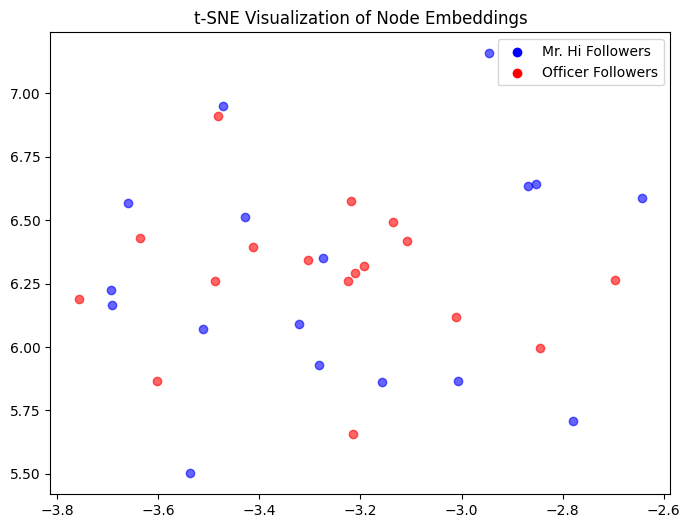

In [138]:
plot_embeddings(embeddings, graph)

Training DeepWalk...
deepwalk_time: 0.07482075691223145 s


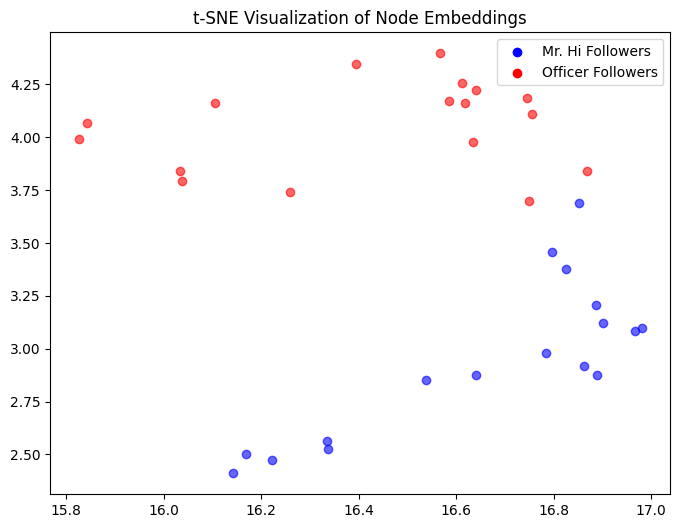

In [139]:
# Compare with DeepWalk
print("Training DeepWalk...")
walks_str = [[str(node) for node in walk] for walk in walks]
start_time = time.time()
deepwalk_model = Word2Vec(sentences=walks_str, vector_size=embedding_dim, window=5, min_count=1, sg=1, workers=4)
end_time = time.time()
deepwalk_time = end_time - start_time
print(f"deepwalk_time: {deepwalk_time} s")
deepwalk_embeddings = np.array([deepwalk_model.wv[str(node)] for node in nodes])
plot_embeddings(deepwalk_embeddings, graph)

Training Node2Vec...


Computing transition probabilities: 100%|██████████| 34/34 [00:00<00:00, 3329.75it/s]

node2vec_time: 0.19739961624145508 s



Generating walks (CPU: 4): 100%|██████████| 20/20 [00:00<00:00, 545.55it/s]


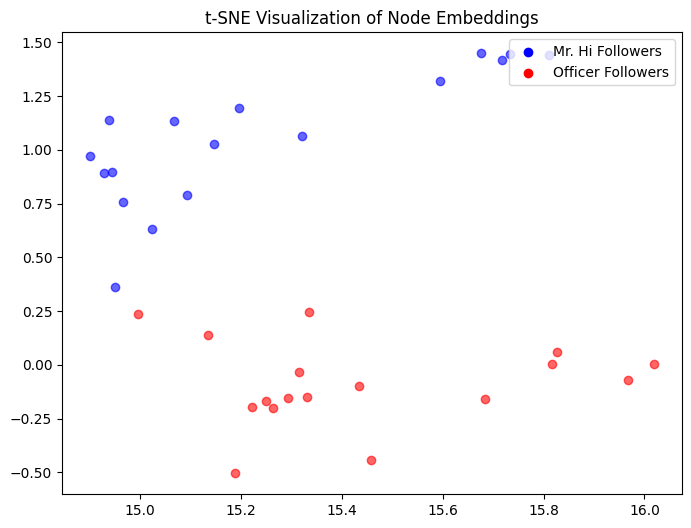

In [140]:
# Compare with Node2Vec
print("Training Node2Vec...")
start_time = time.time()
node2vec = Node2Vec(graph, dimensions=embedding_dim, walk_length=walk_length, num_walks=num_walks, workers=4)
node2vec_model = node2vec.fit(window=5, min_count=1, sg=1)
end_time = time.time()
node2vec_time = end_time - start_time
print(f"node2vec_time: {node2vec_time} s")
node2vec_embeddings = np.array([node2vec_model.wv[str(node)] for node in nodes])
plot_embeddings(node2vec_embeddings, graph)